# Case Study: Customer Lifetime Value (LTV) Prediction

## Table of Contents
1. **Introduction & Problem Statement**
2. **Data Preparation & Engineering**
3. **Exploratory Data Analysis (EDA)**
4. **Modeling & Training**
5. **Modeling Challenges & Technical Reflections**
6. **Future Enhancements & Additional Data**
7. **Operational Strategy & Deployment**

## 1. Introduction

### Problem Statement
The goal of this case study is to build a predictive model for Customer Lifetime Value (LTV) over a 12-month period. In the context of a subscription-based insurance business model, accurate LTV prediction at the time of signup allows for better revenue forecasting, customer acquisition spend and customer segmentation.

**Defining the Metric**
Based on the requirements, the 1-year LTV is defined as:
$$\text{LTV}_{12m} = (\text{Monthly Commission} \times \text{Tenure Months}) + \text{Cross-Sell Commission}$$

**Constraints:**
* **Time Period:** We are strictly looking at value generated within the first 12 months of the customer relationship.
* **Tenure:** Maxed at 12 months. If a user churns after 3 months, tenure is 3. If they stay >12 months, tenure is 12.
* **Data Availability:** Predictions are made using only data available at the moment of signup.

#### Modeling Strategy
I followed an incremental approach, moving from a simple model to a more complicated model.

#### Phase 1: Baseline Model (Regression)
I established a Baseline Model that directly predicts the total 12-month LTV using a single regression algorithm.
* **Purpose:** Provides a quick benchmark from the raw data.

**Mathematical Representation:**
$$\widehat{\text{LTV}}_{12m} = f_{\text{regressor}}(\text{Features})$$

#### Phase 2: Proposed Approach (Composite Model)
To improve interpretability and performance, I implemented a Composite Model that models the revenue logic by splitting the two revenue streams:

1. **Tenure Component (Subscription Revenue):** Instead of predicting yearly commission, this sub-model predicts Tenure Months. By modeling the number of active months (up to 12), we capture the survival probability of a customer.
   
2. **Cross-Sell Component:**
   Since cross-sell events are often rare, I use a Two-Stage Model:
   * **probability Layer:** A classifier to predict the probability of any cross-sell occurring.
   * **Expected Value Layer:** A regressor to estimate the commission amount, conditional on a purchase.

**Mathematical Representation:**
$$\widehat{\text{LTV}}_{12m} = {(C_{m} \cdot \hat{T})} + {(\hat{P}_{cs} \cdot \hat{V}_{cs})}$$

Where:
* $C_{m}$: Fixed monthly commission.
* $\hat{T}$: Predicted Tenure.
* $\hat{P}_{cs}$: Predicted Probability.
* $\hat{V}_{cs}$: Predicted Expected Value.


## 2. Data Preparation & Engineering

The objective of this step is to transform raw data into a analytical dataset. Since the model predicts LTV on signup, we must engineer our target variables.

### Key Engineering Steps:

1. **Handling Data Maturity (Censoring):**  Customers who joined recently haven't had a chance to complete their first 12 months. Including them would bias the model toward lower LTVs.
   * I filtered the dataset to include only mature customers (those who joined at least 365 days ago) or those who have already churned.

2. **Tenure Target Construction:**
   We calculate tenure as the number of months between `customer_started_at` and `customer_churned_at`. 
   * Tenure is capped at 12 months to match our way of modeling.
   * Churn dates are rounded to the nearest month to reflect the monthly billing cycle.

3. **Cross-Sell Logic:**
   Customers may buy multiple additional products over their lifetime. 
   * We filter the cross-sell dataset to only include transactions occurring within the first 365 days of the initial signup. 
   * These transactions are then aggregated per user to create a total 1-year cross-sell value.

4. **Data Integrity & Cleaning:**
   * Handled date anomalies where churn dates preceded start dates.
   * Imputed missing values for `operating_system` as 'other'.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
df_base = pd.read_csv('data/case_study_base.csv')
df_xs = pd.read_csv('data/case_study_xs.csv')

# Adjust date data type
df_base['customer_started_at'] = pd.to_datetime(df_base['customer_started_at'])
df_base['customer_churned_at'] = pd.to_datetime(df_base['customer_churned_at'])
df_xs['date'] = pd.to_datetime(df_xs['date'])

# Adjust operating system
os_to_replace = ['iPadOS', 'iPhone OS']
df_base['operating_system'] = df_base['operating_system'].replace(os_to_replace, 'iOS')

# Create tenure target
initial_rows = len(df_base)
snapshot_date = max(df_base['customer_started_at'].max(), df_base['customer_churned_at'].max())
is_churned = df_base['customer_churned_at'].notna()
df_base['churn_flag'] = is_churned.astype(int)
is_mature = (snapshot_date - df_base['customer_started_at']) >= pd.Timedelta(days=365)
df_base = df_base[is_churned | is_mature]
df_base['end_date'] = df_base['customer_churned_at'].fillna(snapshot_date)
days_diff = (df_base['end_date'] - df_base['customer_started_at']).dt.days
df_base['tenure_months'] = ((days_diff / 30.44).round(0).clip(upper = 12)).astype(int)
dropped_rows = initial_rows - len(df_base)
print(f"Dropped from df_base(not mature): {dropped_rows} dropped rows ({dropped_rows/initial_rows:.2%})")

# Drop date anomalies
initial_rows = len(df_base)
df_base = df_base[df_base['end_date'] >= df_base['customer_started_at']].copy()
dropped_rows = initial_rows - len(df_base)
print(f"Dropped from df_base(date anomalies): {dropped_rows} dropped rows ({dropped_rows/initial_rows:.2%})")

# Add os other
df_base['operating_system'] = df_base['operating_system'].fillna('other')

df_base = df_base.reset_index(drop = True)
df_base.info()


Dropped from df_base(not mature): 9380 dropped rows (9.14%)
Dropped from df_base(date anomalies): 1556 dropped rows (1.67%)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91687 entries, 0 to 91686
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              91687 non-null  object        
 1   customer_started_at  91687 non-null  datetime64[ns]
 2   customer_churned_at  37002 non-null  datetime64[ns]
 3   product              91687 non-null  object        
 4   commission           91687 non-null  float64       
 5   channel              91687 non-null  object        
 6   age_bucket           91687 non-null  object        
 7   operating_system     91687 non-null  object        
 8   churn_flag           91687 non-null  int64         
 9   end_date             91687 non-null  datetime64[ns]
 10  tenure_months        91687 non-null  int64         
dtypes: datetime64[ns](3),

In [3]:
# create cross-sell target
initial_rows = len(df_xs)
df_xs_merged = df_xs.merge(df_base[['user_id', 'customer_started_at']], on = 'user_id')
dropped_rows = initial_rows - len(df_xs_merged)
print(f"Dropped from df_xs(miss-match ids): {dropped_rows} dropped rows ({dropped_rows/initial_rows:.2%})")

# check the date and maturity
initial_rows = len(df_xs_merged)
df_xs_merged = df_xs_merged[
    (df_xs_merged['date'] >= df_xs_merged['customer_started_at']) & 
    (df_xs_merged['date'] <= df_xs_merged['customer_started_at'] + pd.Timedelta(days=365))
]
dropped_rows = initial_rows - len(df_xs_merged)
print(f"Dropped from df_xs(date): {dropped_rows} dropped rows ({dropped_rows/initial_rows:.2%})")

# Aggregate and add flag of xs
initial_rows = len(df_xs_merged)
df_xs_merged['xs_total_value'] = df_xs_merged.groupby('user_id')['commission'].transform('sum')
df_xs_merged['xs_count'] = df_xs_merged.groupby('user_id')['commission'].transform('count')
df_xs_merged['xs_flag'] = 1
dropped_rows = initial_rows - len(df_xs_merged)
print(f"cross sell number: {dropped_rows} dropped rows ({dropped_rows/initial_rows:.2%})")

df_xs_merged = df_xs_merged.reset_index(drop=True)
df_xs_merged.info()


Dropped from df_xs(miss-match ids): 148 dropped rows (11.23%)
Dropped from df_xs(date): 684 dropped rows (58.46%)
cross sell number: 0 dropped rows (0.00%)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              486 non-null    object        
 1   product              486 non-null    object        
 2   commission           486 non-null    float64       
 3   date                 486 non-null    datetime64[ns]
 4   customer_started_at  486 non-null    datetime64[ns]
 5   xs_total_value       486 non-null    float64       
 6   xs_count             486 non-null    int64         
 7   xs_flag              486 non-null    int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(2)
memory usage: 30.5+ KB


In [4]:
# Create unique cross-sell table to avoid duplicates during merge
df_xs_unique = df_xs_merged[['user_id', 'xs_total_value', 'xs_count', 'xs_flag']].drop_duplicates()


# Combine dataframes
initial_rows = len(df_base)
df_final = df_base.merge(df_xs_unique, on='user_id', how='left')


# Fill missing values for customers with no cross-sell transactions
df_final['xs_total_value'] = df_final['xs_total_value'].fillna(0)
df_final['xs_flag'] = df_final['xs_flag'].fillna(0)
df_final['xs_count'] = df_final['xs_count'].fillna(0)


# Calculate the 12-month LTV
df_final['ltv_12m'] = (df_final['commission'] * df_final['tenure_months']) + df_final['xs_total_value']
#df_final['ltv_12m'] = (df_final['commission'] * df_final['tenure_months'])
print(f"Final dataset rows: {len(df_final)} (Original base rows: {initial_rows})")
df_final.info()


Final dataset rows: 91687 (Original base rows: 91687)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91687 entries, 0 to 91686
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              91687 non-null  object        
 1   customer_started_at  91687 non-null  datetime64[ns]
 2   customer_churned_at  37002 non-null  datetime64[ns]
 3   product              91687 non-null  object        
 4   commission           91687 non-null  float64       
 5   channel              91687 non-null  object        
 6   age_bucket           91687 non-null  object        
 7   operating_system     91687 non-null  object        
 8   churn_flag           91687 non-null  int64         
 9   end_date             91687 non-null  datetime64[ns]
 10  tenure_months        91687 non-null  int64         
 11  xs_total_value       91687 non-null  float64       
 12  xs_count             91687 non-nul

In [5]:
df_final[['commission', 'churn_flag', 'tenure_months', 'xs_total_value', 'xs_flag', 'ltv_12m']].describe()

,commission,churn_flag,tenure_months,xs_total_value,xs_flag,ltv_12m
count,91687.000000,91687.000000,91687.000000,91687.000000,91687.000000,91687.000000
mean,13.461217,0.403569,10.024725,3.701598,0.004646,136.137955
std,3.844458,0.490616,3.792569,69.746797,0.068005,94.097002
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.880000,0.000000,12.000000,0.000000,0.000000,120.000000
50%,12.560000,0.000000,12.000000,0.000000,0.000000,146.160000
75%,13.450000,1.000000,12.000000,0.000000,0.000000,156.600000
max,136.410000,1.000000,12.000000,4330.000000,1.000000,4472.320000


### Data Quality Notes & Assumptions

After processing the raw datasets, I observed several key points that informed the final data structure:

* **Data Anomalies (Negative Tenure):** 
    * I identified rows where the customer_churned_at date was earlier than the customer_started_at. These were treated as data entry errors and removed to ensure model integrity.
* **Instant Cancellations:** 
    * I accounted for "zero-month" tenures where customers cancelled almost immediately. These are included as they represent a specific high-churn segment.
* **Maturity Filter vs. Data Volume:** 
    * Filtering for a 12-month history reduces the training size. 
    * I prioritized data correctness over volume. Training an LTV model on customers who only joined 1 month ago would lead to a model that underestimates value.
* **Cross-Sell Aggregation:** 
    * I aggregated multiple purchases per user (sum and count) to ensure the total 12-month value is captured.
    * I strictly limited this to the 365-day window from the initial sign-up to align with the 1-year LTV definition.

## 3. Exploratory Data Analysis (EDA)

In this section, we explore the features of LTV by analyzing customer behavior across segments.

### 3.1 Univariate Analysis: Target Distributions
We first look at the distribution of our targets.

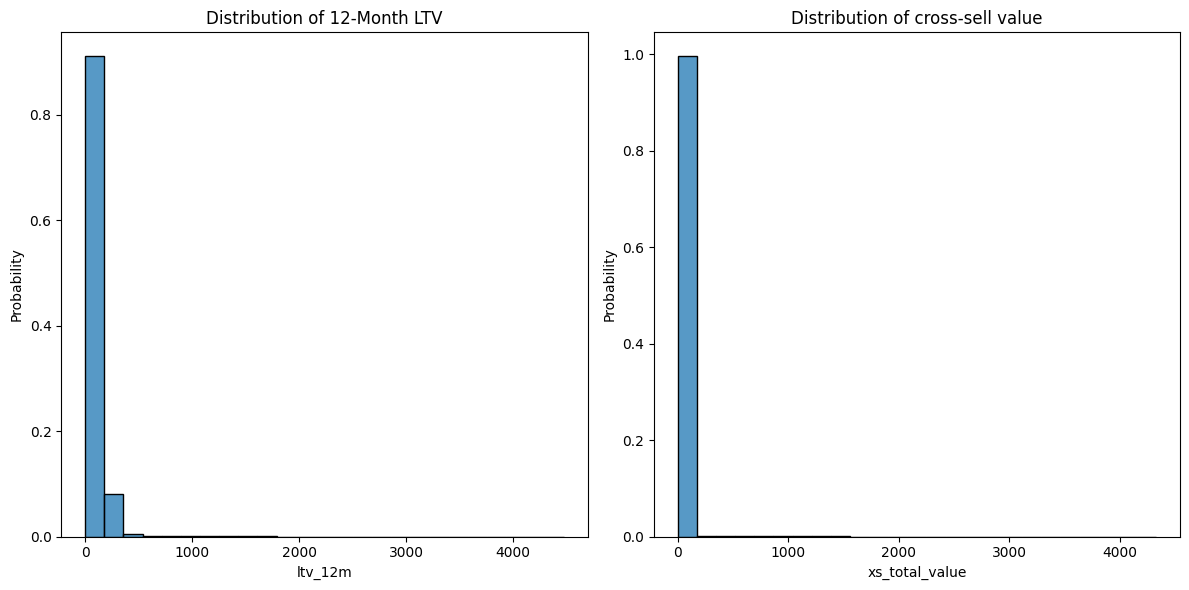

In [6]:
# plot distribution of 12-Months LTV and cross-sell value
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_final['ltv_12m'], bins = 25, stat = 'probability')
plt.title('Distribution of 12-Month LTV')

plt.subplot(1, 2, 2)
sns.histplot(df_final['xs_total_value'], bins = 25, stat = 'probability')
plt.title('Distribution of cross-sell value')

plt.tight_layout()
plt.show()


**Key Insights: Target Distribution**
* **Non-Normal Distribution:** The LTV distribution is heavily right-skewed, confirming that a standard linear regression model will struggle with this target.
* **The "Whale" Effect:** The Cross-Sell Value xs_total_value is inflated with low values. The vast majority of customers have small cross-sell value, while a small "long tail" of high-value customers drives disproportionate revenue. This justifies separating the cross-sell modeling task from the main subscription prediction.

Text(0.5, 1.0, 'Churn Class Balance')

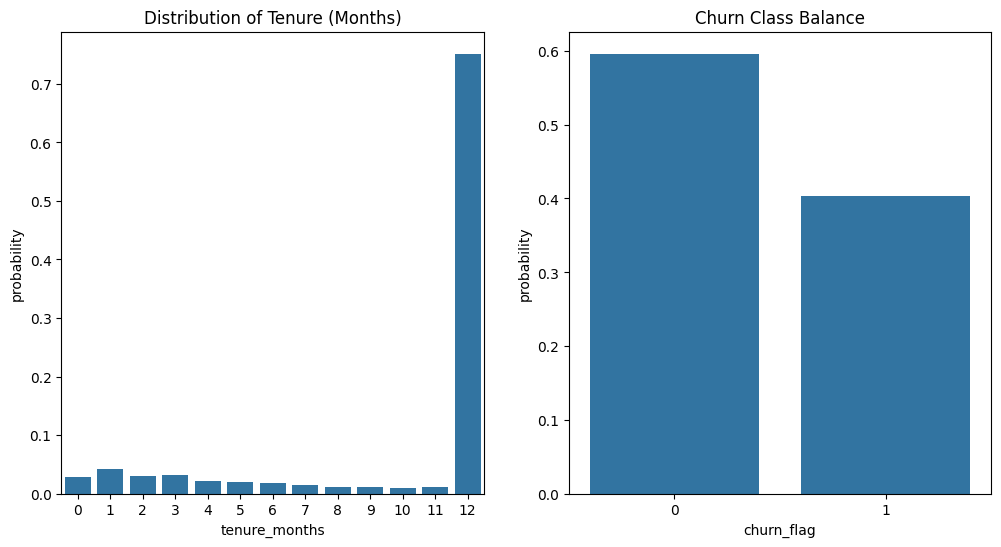

In [7]:
# plot distribution of tenure months and churn_flag
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x = 'tenure_months', data = df_final, stat = 'probability')
plt.title('Distribution of Tenure (Months)')

plt.subplot(1, 2, 2)
sns.countplot(x = 'churn_flag', data = df_final, stat = 'probability')
plt.title('Churn Class Balance')

**Key Insights: Tenure Profile**
*  The tenure distribution is not linear; it is skewed. Customers tend to churn at 12 months or remain loyal for the full term.
* **Strategic Implication:** The high concentration of users at the 12-month mark suggests that "Retention" is binary in nature, supporting the decision to use a Classifier for the tenure component rather than a Regressor.

### 3.2 Bivariate Analysis: Segment Insights

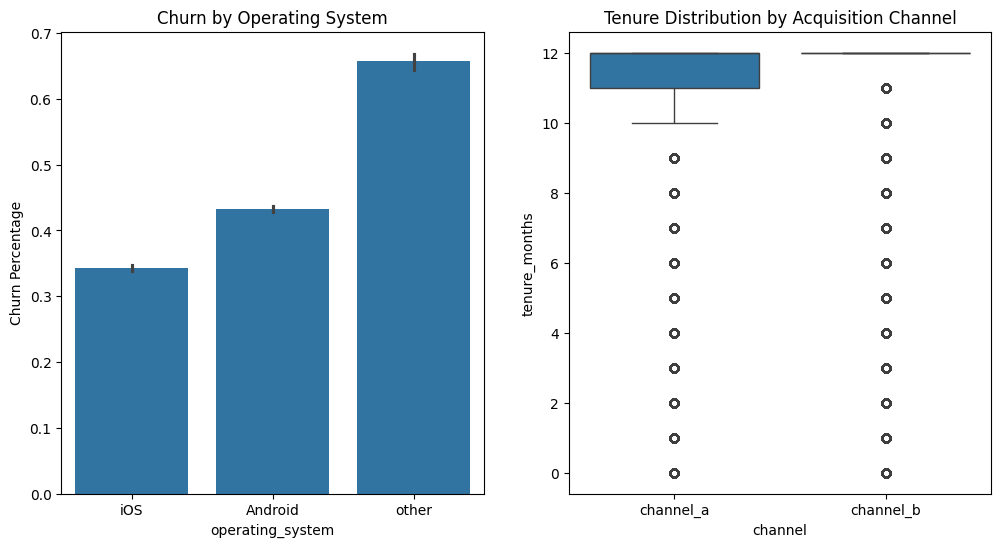

In [8]:
# Investigate churn by operating system and tenure distribution by channel
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x = 'operating_system', y = 'churn_flag', data = df_final)
plt.title('Churn by Operating System')
plt.ylabel('Churn Percentage')

plt.subplot(1, 2, 2)
sns.boxplot(x = 'channel', y = 'tenure_months', data = df_final)
plt.title('Tenure Distribution by Acquisition Channel')

plt.show()

Text(0.5, 1.0, 'Churn Probability by channel')

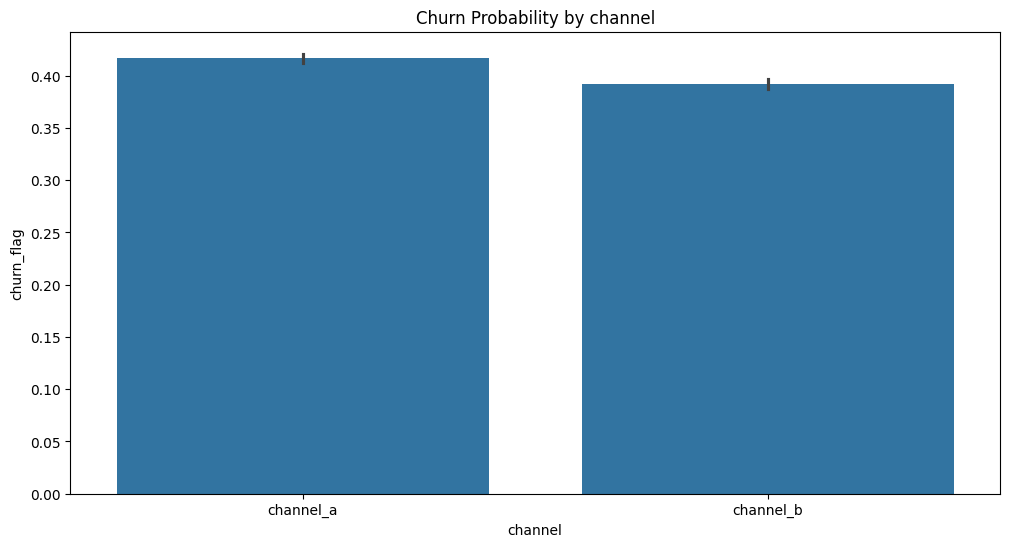

In [9]:
# investigate Churn Probability by channel
plt.figure(figsize = (12, 6))

sns.barplot(x = 'channel', y = 'churn_flag', data = df_final)
plt.title('Churn Probability by channel')

**Key Insights: Segment Risks**
* **Platform Friction:** There is a massive loyalty gap between Operating Systems. iOS users are the most stable (~35% churn), whereas "Other" OS users have a churn rate exceeding 65%. This indicates potential technical bugs or poor UX on non-standard platforms.
* **Acquisition Quality:** Channel B stands out as a high-quality source, with nearly all acquired users reaching the full 12-month tenure.

Text(0.5, 1.0, 'Cross-sell Probability by Initial Product')

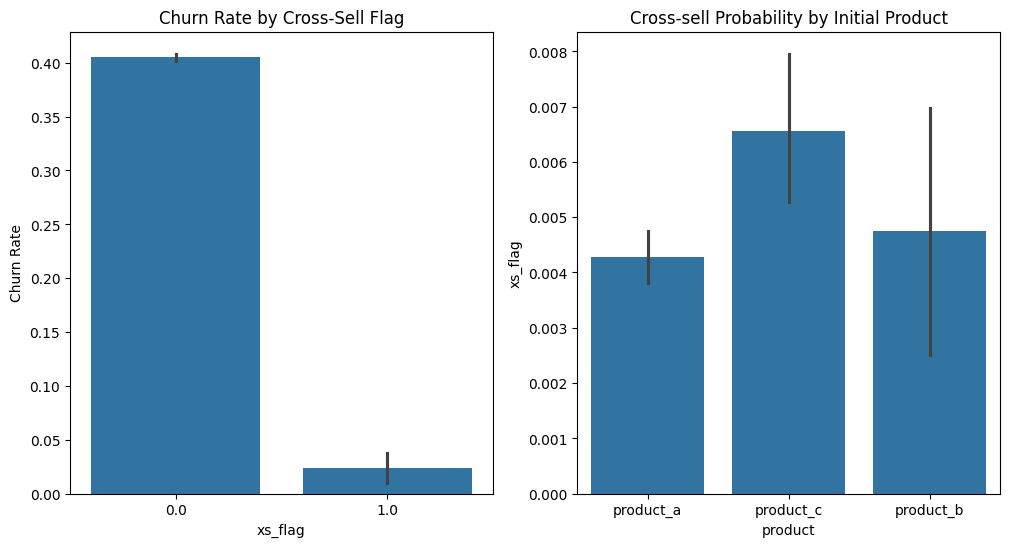

In [10]:
# Investigate Churn Rate by Cross-Sell Flag and Cross-sell Probability by Initial Product
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x = 'xs_flag', y = 'churn_flag', data = df_final)
plt.title('Churn Rate by Cross-Sell Flag')
plt.ylabel('Churn Rate')

plt.subplot(1, 2, 2)
sns.barplot(x = 'product', y = 'xs_flag', data = df_final)
plt.title('Cross-sell Probability by Initial Product')

**Key Insights:**
* The data reveals a near-deterministic relationship: churn for customers with a cross-sell drops to near 0%. Getting a customer to buy a second product is a guarantee of 12-month retention.
* **Product C** has the highest probability of leading to a cross-sell. Strategically, funneling new users into Product C could maximize long-term portfolio value.

--- Global Revenue Breakdown ---
Total Subscription Commission: 12,142,692.24
Total Cross-Sell Commission:  339,388.45
Total 12-Month Portfolio Value: 12,482,080.69


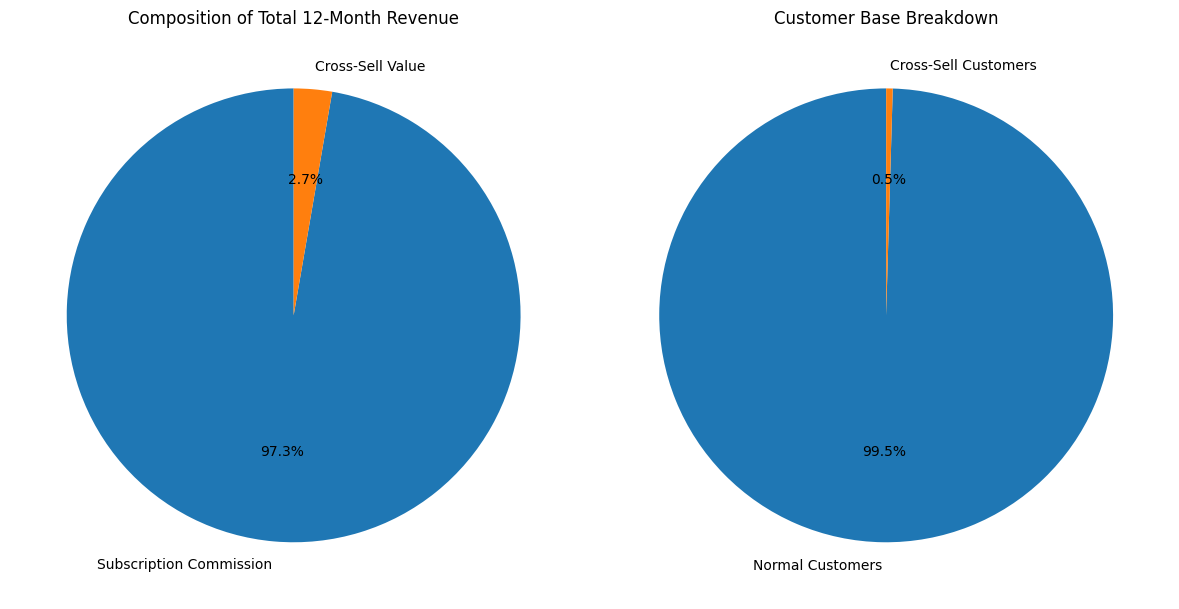

In [11]:
total_comm = (df_final['commission'] * df_final['tenure_months']).sum()
total_xs = df_final['xs_total_value'].sum()
total_yearly_income = total_comm + total_xs

print(f"--- Global Revenue Breakdown ---")
print(f"Total Subscription Commission: {total_comm:,.2f}")
print(f"Total Cross-Sell Commission:  {total_xs:,.2f}")
print(f"Total 12-Month Portfolio Value: {total_yearly_income:,.2f}")

total_customers = len(df_final)
cross_sell_customers = df_final['xs_flag'].sum()
normal_customers = total_customers - cross_sell_customers

plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.pie([total_comm, total_xs], 
        labels = ['Subscription Commission', 'Cross-Sell Value'], 
        autopct = '%1.1f%%', startangle = 90)
plt.title('Composition of Total 12-Month Revenue')

plt.subplot(1, 2, 2)
plt.pie([normal_customers, cross_sell_customers], 
        labels = ['Normal Customers', 'Cross-Sell Customers'], 
        autopct = '%1.1f%%', startangle = 90)
plt.title('Customer Base Breakdown')

plt.tight_layout()
plt.show()


**Key Insights: Revenue vs. Volume**
* While Cross-Sell customers represent a tiny fraction of the total user base (Volume), they represent the highest "quality" of revenue due to their zero-churn profile.

## 4. Modeling & Training

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

import xgboost as xgb

In [13]:
features = ['product', 'commission', 'channel', 'age_bucket', 'operating_system']
X = df_final[features].copy()
y = df_final['ltv_12m']

X = pd.get_dummies(X, columns=['product', 'channel', 'age_bucket', 'operating_system'], drop_first = True)

In [14]:
# First split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

# Second split
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state = 42)

print(f"Train size: {len(X_train)}")
print(f"Val size:   {len(X_val)}")
print(f"Test size:  {len(X_test)}")

Train size: 55011
Val size:   18338
Test size:  18338


### 4.1 Baseline: Linear Regression

In [15]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_val = lr_model.predict(X_val)

lr_mae = mean_absolute_error(y_val, y_pred_val)
lr_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
lr_r2 = r2_score(y_val, y_pred_val)

print("--- Linear Regression Direct LTV Regression ---")
print(f"Validation MAE:  {lr_mae:.2f}")
print(f"Validation MSE: {lr_rmse:.2f}")
print(f"Validation R2:   {lr_r2:.4f}")

--- Linear Regression Direct LTV Regression ---
Validation MAE:  42.13
Validation MSE: 98.25
Validation R2:   0.0768


The first phase establishes a benchmark by attempting to predict the total 12-month LTV using a single regression algorithm.

* **Algorithm:** Linear Regression
* **Input Features:** Initial product, monthly commission, acquisition channel, age bucket, and operating system.
* **Target:** ltv_12m

**Evaluation:** linear regression struggles to account for the categorical nature of the dataset.

### 4.2 Experiment: Direct XGBoost Regressor

In [16]:
xgb_model = xgb.XGBRegressor(n_estimators = 100, max_depth = 10, learning_rate = 0.02)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)

xgb_mae = mean_absolute_error(y_val, y_pred_xgb)
xgb_rmse = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
xgb_r2 = r2_score(y_val, y_pred_xgb)

print("--- XGBoost Direct LTV Regression ---")
print(f"Validation MAE:  {xgb_mae:.2f}")
print(f"Validation RMSE: {xgb_rmse:.2f}")
print(f"Validation R2:   {xgb_r2:.4f}")

--- XGBoost Direct LTV Regression ---
Validation MAE:  40.17
Validation RMSE: 97.42
Validation R2:   0.0924


To capture non-linear relationships and segment-specific interactions, I implemented an XGBoost Regressor to predict the LTV directly.

* **Hyperparameters:** 250 estimators, max depth of 100, and a learning rate of 0.01.

**Evaluation:** XGboost was not able to handle the skews in the data also.

### 4.3 Proposed Solution: Composite Model

**1. The Tenure Component**
Instead of predicting dollars directly, this sub-model predicts the number of active months.

* **Algorithm**: XGBoost Classifier.

In [17]:
y_train_tenure = df_final.loc[X_train.index, 'tenure_months']
y_val_tenure = df_final.loc[X_val.index, 'tenure_months']

model_tenure = xgb.XGBClassifier(n_estimators = 100, max_depth = 10, learning_rate = 0.02)
model_tenure.fit(X_train, y_train_tenure)

pred_tenure_months = model_tenure.predict(X_val)

pred_churn_rate = (pred_tenure_months == 12)
y_churn_rate = (y_val_tenure == 12)
accuracy = accuracy_score(y_churn_rate, pred_churn_rate)
print("--- Churn rate accuracy ---")
print(f'Validation accuracy: {accuracy:.4f}')

tenure_accuracy = accuracy_score(y_val_tenure, pred_tenure_months)
print("--- XGBoost tenure months ---")
print(f"Validation Accuracy: {tenure_accuracy:.2f}")

--- Churn rate accuracy ---
Validation accuracy: 0.7565
--- XGBoost tenure months ---
Validation Accuracy: 0.75


**2. The Cross-Sell Component**
This model predicts the probability of cross sell.

* **Algorithm**: XGBoost Classifier.

In [18]:
y_train_xs = df_final.loc[X_train.index, 'xs_flag']
y_val_xs = df_final.loc[X_val.index, 'xs_flag']

model_xs_prob = xgb.XGBClassifier(n_estimators=100, max_depth=6, use_label_encoder=False, eval_metric='logloss')
model_xs_prob.fit(X_train, y_train_xs)
pred_xs_prob = model_xs_prob.predict_proba(X_val)[:, 1]


c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:50:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


**3. Expected Cross Sell Value Component**
This model predicts the value of cross sell if it happens.

* **Algorithm**: XGBoost Regressor.

In [19]:
train_xs_only = df_final.loc[X_train.index][df_final['xs_flag'] == 1]
X_train_xs = X_train.loc[train_xs_only.index]
y_train_xs_value = train_xs_only['xs_total_value']

model_xs_value = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.05, random_state=42)
model_xs_value.fit(X_train_xs, y_train_xs_value)

pred_xs_value_raw = model_xs_value.predict(X_val)


C:\Users\dell\AppData\Local\Temp\ipykernel_20252\3317677778.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_xs_only = df_final.loc[X_train.index][df_final['xs_flag'] == 1]


In [20]:
val_commissions = X_val['commission']

composite_ltv_pred = (val_commissions * pred_tenure_months) + (pred_xs_prob * pred_xs_value_raw)

comp_mae = mean_absolute_error(y_val, composite_ltv_pred)
comp_rmse = np.sqrt(mean_squared_error(y_val, composite_ltv_pred))

print(f"Composite Model MAE: {comp_mae:.2f}")
print(f"Composite Model RMSE: {comp_rmse:.2f}")

Composite Model MAE: 35.78
Composite Model RMSE: 103.84


* **Conclusion:** The Composite Model is a better choice as it has the lowest MAE. Moreover, it provides the business with actionable insights: we can now distinguish between a customer with low value due to churn risk versus a customer with low value due to low cross-sell propensity. The gap between the RMSE and the MAE confirms the effect of the outliers on the model.

* **Note:** I changed from an XGBRegressor to an XGBClassifier for the tenure months. Given the nature of the data, classification more effectively captures these peaks without the regression to the mean bias that often weakens the signal in survival-based datasets.

## 5. Modeling Challenges & Technical Reflections

During the models development, several data characteristics showed as hurdles to high-accuracy prediction:

* **Data Distribution Bias:** 
    * The dataset is heavily skewed toward the 12-month mark, meaning the majority of customers in this sample remain active for the full year. Because there is such a high concentration of "loyal" data points compared to a smaller number of early churners, the problem is more naturally suited for Churn Prediction rather than a standard linear Tenure Regression

* **Outliers:** 
    * A small minority provides massive value through cross-sells. These outliers significantly pull the mean, leading to high RMSE and making it difficult for the algorithms to converge on a "typical" customer profile.

* **Feature Signal at Signup:** 
    * Since we are limited to data available only at the moment of signup, we lack the behavioral indicators that typically occur during the customer lifecycle which would normally refine an LTV estimate.

   

## 6. Future Enhancements & Additional Data

To significantly improve predictive accuracy, I recommend integrating the following data sources to capture the customer lifecycle:

* **Behavioral Data:** 
    * How often a user opens the Getsafe app in the first 30 days is a leading indicator of retention. High engagement usually correlates with lower churn.
* **Claims History:** 
    * In insurance, users who file a claim early often have a different LTV profile. Either they become very loyal because of good service, or they churn if the claim is denied.
* **Payment Method:**
    * Users on Credit Cards vs. PayPal vs. Direct Debit often have different churn rates.
* **Marketing Format:**
    * Knowing the specific Creative or Campaign not only the channel would help to identify the type of customer we are attracting.

## 7. Operational Strategy & Deployment

To translate this model into business value, I propose the following deployment steps:

### 7.1 Inference Pipeline
* **Batch Scoring:** The model runs on a schedule, scoring all customers acquired in the previous 24 hours.
* **Multi-Signal Output:** For every new user, the system generates three distinct signals:
    1. **Retention Risk Class:** (High Risk / Safe) via the Tenure Classifier.
    2. **Upsell Probability:** (High / Low) via the Cross-Sell Probability model.
    3. **Predicted 12-Month LTV:** The final estimated money value for financial forecasting.

### 7.2 Practical Business Applications
Once the model provides a score for a customer, the business can take actions:

* **For High-Risk Customers (Predicted Tenure < 3 months):**
    * Focus on Retention: Send a "Welcome" survey or a helpful guide on how to use the insurance app. The goal is to make the customer feel supported early on.

* **For High-Value Targets (High Cross-Sell Probability):**
    * Focus on Growth: Highlight other insurance products in their first monthly newsletter. Since the model says they are likely to buy more, we should show them more offers.

* **For Stable Customers (Predicted Tenure = 12 months):**
    * Focus on Loyalty: These are our best customers. We should keep their experience smooth and avoid sending them too many marketing emails, as they are already providing steady value.

* **Budget Planning:**
    * Use the Predicted LTV to decide how much we should spend on marketing. If a specific channel (META ADs) brings in many "High-Risk" customers, we should consider spending less there and moving the budget to channels that bring in "Loyal" customers.

### 7.3 Model Monitoring & Governance
* **Performance Tracking:** Monthly monitoring of MAE and Churn Accuracy to detect drift in data (if a new marketing channel brings in a different demographic of users).
* **A/B Validation:** Running a test where a control group receives random offers while the treatment group receives model-based targeting to measure the actual uplift in LTV.